<br><br>
<center><span style="font-size: 170%"><b>
Parameter Estimation of one-dimensional advection diffusion equation by Monte-Carlo Filter  
</b></span></center>
<center><span style="font-size: 110%">（モンテカルロフィルタを用いた一次元移流拡散方程式の状態推定）</span></center>


<div align="right"><span style="font-size: 110%">2018年7月17日</span></div>
<div align="right"><span style="font-size: 110%">03-160973 榊　拓馬</span></div>

***

### Overview
Objective：Conduct parameter estimation by Monte-Carlo Filter, and confirm its availability<br>
Method：For the analyzable one-dimensional advection diffusion equation, estimate the advection velocity $u$ and the diffusion coefficient $D$ by Monte-Carlo Filter

###### Contents

    1.　Outline of equation and analytical solution
    2. Numerical solution and simulation error
    3. Formulation of system equations and measurement equations
    3. Parameter Estimation by Monte-Carlo Filtering

<hr>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
from numpy.random import *
from decimal import *
from tqdm import tqdm

### 1.　Outline of equation and analytical solution

The one-dimensional advection diffusion equation is below.
$$\frac{\partial C(x,t)}{\partial t} + u\frac{\partial C(x,t)}{\partial x} =  D\frac{\partial^2 C(x,t)}{\partial x^2}$$
<br>
Here, $u$ is advection speed, and $D$ is diffusion coefficient. And in this section, we assume periodic boundary condition $C(x+x_m) = C(x)$.

Moreover, in this section, I make use of the analytical solution below.

$$C(x,t)= \frac{1}{2\sqrt{\pi D t}}exp\{-\frac{(x-2-ut)^2}{4D t}\}　$$

This is the solution which impulse distribution at $t=0, x=2$ spreads with being advected.

We define true values and the bounddary like the table below, and set $t=0.01$ as initial condition.

|Advection speed $u$ |  Diffusion coefficient $D $ | boundary $x_m$ |
|:-:|:-:|:-:|
|$10m\dot{} s$  |$1.0m^2\dot{}s$  |$10m$|

In [2]:
def Analytical_Solution(x,t, u=10, D=1):
    return np.exp(-1 * ((x-2-u * t)**2) / (4 * D * t) ) / (2 * np.sqrt(np.pi * D* t))

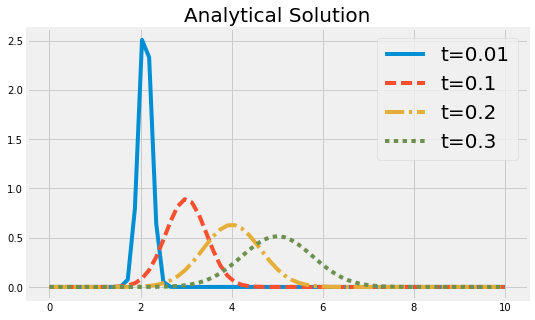

In [3]:
x = np.linspace(0,10,65)
plt.figure(figsize=(8,5))
plt.title("Analytical Solution", fontsize = 20)
plt.plot(x, Analytical_Solution(x,0.01), linestyle="-", linewidth=4, label="t=0.01")
plt.plot(x, Analytical_Solution(x,0.1),  linestyle="--",linewidth=4, label="t=0.1")
plt.plot(x, Analytical_Solution(x,0.2),linestyle="-.", linewidth=4, label="t=0.2")
plt.plot(x, Analytical_Solution(x,0.3),linestyle=":", linewidth=4, label="t=0.3")
plt.legend(loc='upper right', fontsize=20)

***

### 2 Numerical solution and simulation error

#### 2.1 Spectrum expression of horizontal direction

We calculate the analytical solution by numerical solution using spectrum method, and central difference method is applied to spatial discretization.

Here the spatial discrete representation of the governing equation is:

$$\frac{\partial C_i(t)}{\partial t} + u\frac{\partial C_i(t)}{\partial x} =  D\frac{\partial^2 C_i(t)}{\partial x^2}$$

$C_i(t)$ is expanded by spectrum inverse transformation as follows. ($I$: number of grid points in $x$ direction, $K$: cutting wave number)

$$C_i(t) = \sum^{K-1}_{k=0}exp(\frac{2\pi ikx_i}{x_m}) \hat{C_k}$$

On the other hand, the spectral coefficient $\hat{C_k}$ is given by the following spectral transformation.

$$\hat{C_k} = \frac{1}{I}\sum^{I}_{i=0} exp(-\frac{2\pi ikx_i}{x_m}) C_i$$

Then, the spectrum expression of governing equation is given as follows.

$$\frac{\partial \hat{C_k}}{\partial t} =  -u（\frac{2\pi ik}{x_m}）\hat{C_k} +  D{(\frac{2\pi ik}{x_m})}^2\hat{C_k}$$

#### 2.2 Discretization in time direction

To discretize time direction, we applied Adams-Bashforth+Crank-Nicholson method (but only for the first step, we used Euler method)

###### <u>2.2.1　Euler method</u>
By discretizing the above equation in the time direction using the Eular scheme, it is expressed as follows.

$$\hat{C^{\tau+1}_k} = \hat{C^\tau_k} + \Delta t \{-u（\frac{2\pi ik}{x_m}）\hat{C^\tau_k} +  D{(\frac{2\pi ik}{x_m})}^2\hat{C^\tau_k} \} $$

###### <u>2.2.2 Adams-Bashforth+Crank-Nicholson method </u>
If using Adams-Bashforth method to the advection term and Crank-Nicholson method to the diffusion term, the equation is expressed as follows.

$$  \{ 1 - \frac{D\Delta t}{2}(\frac{2\pi ik}{x_m})^2) \} \hat{C^{\tau+1}_k}  =\hat{C^\tau_k} - \frac{u \Delta t}{2}(\frac{2\pi ik}{x_m})(3\hat{C^{\tau}_k}-\hat{C^{\tau-1}_k}) + \frac{D \Delta t}{2} (\frac{2\pi ik}{x_m})^2 \hat{C^{\tau}_k}$$

#### 2.3　Numerical Analysis

Here, we conduct numerical analysis, defining some variables as below.

|time interval $\Delta t$ | the number of grid points $I$　|the number of cutting waves $K$| 
|:-:|:-:|:-:|
|$0.001s $ | $64$| $64$ |

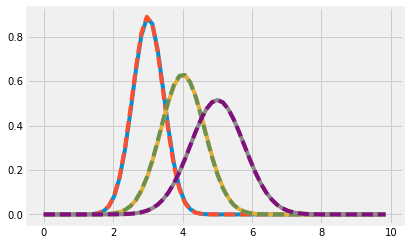

In [4]:
#各変数の設定
x_m = 10.0
I = 64
K = I
true_u = 10
true_D = 1.0
x = np.linspace(0, x_m, I+1, dtype='f16')[:-1]
dt = 0.001

#解
ans = pd.DataFrame(None)
ans['Time'] = np.arange(0.01, 0.3101, dt)
C_hats = np.empty([len(ans), K], dtype='c32')

#オイラー法ステップ
def Step(C_hat, u, D, dt =0.0001, x_m=5.0):
    newC_hat = np.empty(len(C_hat), dtype='c32')
    p = (1/x_m)*2*np.pi*1j* np.arange(len(C_hat))
    newC_hat = C_hat + dt*(-1*u*p*C_hat + D*(p**2)*C_hat)
    return newC_hat

#Adams-Bashforth+Crank-Nicholsonスキーム
def AC_Step(C_hat, C_hat_1, u, D, dt =0.0001, x_m=5.0):
    newC_hat = np.empty(len(C_hat), dtype='c32')
    p = (1/x_m)*2*np.pi*1j* np.arange(len(C_hat))
    newC_hat = (1/(1-D*dt*(p**2)/2))*(C_hat - u*dt*p*(3*C_hat-C_hat_1)/2+D*dt*(p**2)*C_hat/2)
    return newC_hat

#初期値はt=0.01
C0 = Analytical_Solution(x,0.01, u=true_u, D=true_D)
C_hats[0] = np.fft.fft(C0, n=K)

#計算
for i in range(0, len(ans)-1):
    if(i==0):
        C_hats[i+1] = Step(C_hats[i], true_u, true_D, dt, x_m)
    else:
        C_hats[i+1] = AC_Step(C_hats[i], C_hats[i-1], true_u, true_D, dt, x_m)

#結果格納
tmp = pd.DataFrame(C_hats)
ans = pd.concat([ans, tmp], axis=1)
ans.set_index('Time', inplace=True)

#t=0.1, 0.2, 0.3を逆rfftで復元
C1 = np.fft.irfft(np.array(ans[0.1:0.1+dt]), n=I)[0]
C2 = np.fft.irfft(np.array(ans[0.2:0.2+dt]),n=I)[0]
C3 = np.fft.irfft(np.array(ans[0.3- dt/2:]), n=I)[0]

plt.plot(x, C1,linewidth=4)
plt.plot(x, Analytical_Solution(x,0.1),  linestyle="--",linewidth=4, label="True")
plt.plot(x, C2,linewidth=4)
plt.plot(x, Analytical_Solution(x,0.2),  linestyle="--",linewidth=4, label="True")
plt.plot(x, C3,linewidth=4)
plt.plot(x, Analytical_Solution(x,0.3),  linestyle="--",linewidth=4, label="True")

In this graph, the solid lines are the result of numerical solution, and the dotted lines are that of analytical solution at t=0.1, 0.2 or 0.3. So this graph shows the correspondence of the results.

#### 2.4 Evaluation of Simulation Error

Here, we write observation values as $y^\tau_i$, and check the distribution of model error : $y^\tau_i - C^\tau_i$. In order to calculate likelihood of observation in Monte-Carlo Filtering, it is preferable that we can regard this error term as i.i.d sample from any distribution.

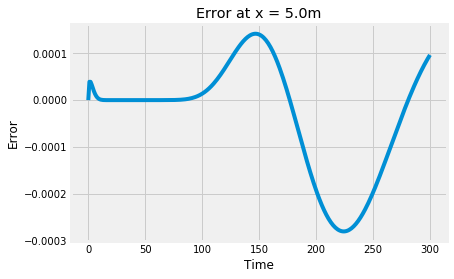

In [5]:
error = np.empty([len(ans), I])
for i in range(len(ans)):
    time = 0.01 + i*dt
    y = Analytical_Solution(x,time, u=true_u, D=true_D)
    c = np.fft.irfft(np.array(ans[time - 0.0005: time+0.0005]), n=I)[0]
    error[i] = y - c
error = error.T
#i = 0における誤差の分布
plt.plot(error[32])
plt.xlabel("Time")
plt.ylabel("Error")
plt.title("Error at x = 5.0m")

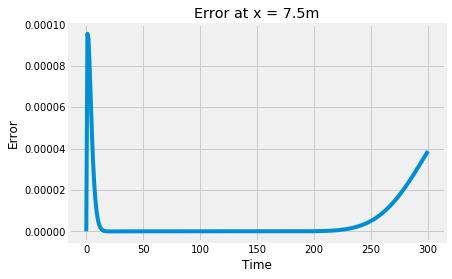

In [6]:
#i = 0における誤差の分布
plt.plot(error[48])
plt.xlabel("Time")
plt.ylabel("Error")
plt.title("Error at x = 7.5m")

However, it's difficult to regard as i.i.d samples because the errors are very systematic. Then, we try to calculate the likelihood from the distribution of MAE. (We can substitute other indicators such as MSE, but we will use MAE with relatively small influence of outliers)

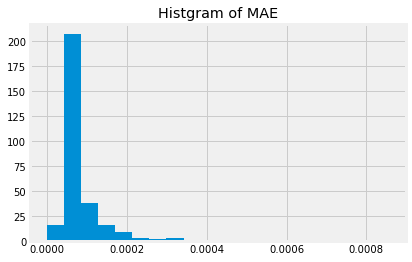

In [8]:
def mae(e):
    return np.sum(np.abs(e)) / len(e)

mae_s = np.empty(len(ans))
for i in range(len(ans)):
    time = 0.01 + i*dt
    y = Analytical_Solution(x,time, u=true_u, D=true_D)
    c = np.fft.irfft(np.array(ans[time - 0.0005: time+0.0005]), n=I)[0]
    e = y - c
    mae_s[i] = mae(e)
plt.hist(mae_s, bins = 20)
plt.title("Histgram of MAE")
plt.show()

Although it becomes somewhat arbitrary here, 0 to 0.0004 is divided into 10 classes, and its frequency / total number is regarded as the realization probability that the model error & observation error is included in the class. Also, in deriving the probability density function  $f_ {MAE} (x) $, we assume $ f_ {MAE}(x> 0.001) = 0 $ because $ max(MAE) \approx 0.00086 $. In actual applied research, since it is not known the true value, it is important to note that evaluation of this error distribution is very difficult and important.

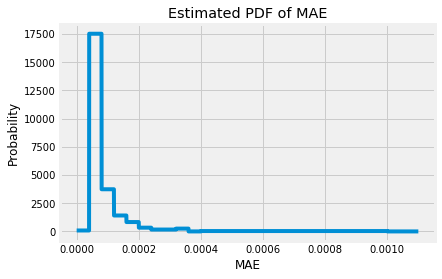

In [9]:
dosuu = np.zeros(11)
for mae in mae_s:
    for j in range(10):
        high = 0.00004 * (j+1)
        if mae < high:
            dosuu[j] += 1
            break
        if j == 9:
            dosuu[10] += 1

dosuu = dosuu/dosuu.sum()
for i in range(10):
    dosuu[i] = dosuu[i] / 0.00004
dosuu[10] = dosuu[10] / (0.001-0.0004)

def f_mae(mae):
    dosuu = np.array([83.05647841, 17524.91694352, 3737.54152824, 1411.96013289, 830.56478405, 332.22591362
                      , 166.11295681, 166.11295681, 249.16943522, 0. , 33.22259136])
    if mae > 0.001:
        return 0.0000000000000000001
    for i in range(10):
        high = 0.00004  * (i + 1)
        if mae < high:
            return dosuu[i]
    return dosuu[10]

array_f_mae = np.frompyfunc(f_mae,1,1)

x = np.linspace(0,0.0011,10000)
plt.plot(x,array_f_mae(x))
plt.xlabel("MAE")
plt.ylabel("Probability")
plt.title("Estimated PDF of MAE")

### 3. Formulation of space state model

#### 3.1 Self-organizing

Based on the above results, we formulate a state space model. First, for each parameter, state as follows according to Liu and West (2001).

$$p(\theta_{t+1}|\theta_t) ∼ N(a\theta_t + (1 − a)\overline{\theta_t}, h^2V_t)$$

$\overline{θ_t}$ is the average of the particle values presented as $θ_t$. $V_t$ is the variance, and $h^2 =1-a^2 $, $ a =(3δ_l-1) / 2 δ_l$. Here, $ δ_l = (0, 1] $, and $ δ_l = 0.97 $ is applied.

#### 3.2 Model Equations

Self-organizing, and let the state variables in the one-dimensional advection diffusion equation be $ u_\tau, D_\tau, \hat{C ^ \tau_k} (k = 0, 1, ..., 63) $. Furthermore, we treat the actual observed value $ y^\tau_i $ as an observation series. And the mean absolute error of observation error $\epsilon^{\tau}_i $, ${mae}_{\tau}$ is obtained by $ f_{MAE} $ which we defined previous chapter. At this time, the model equation can be written as follows.

<b>3.2.1 System Equation</b>

$$D_\tau \sim N(aD_{\tau-1} + (1 − a)\overline{D_{\tau-1}}, h^2V_{\tau - 1}) $$
$$u_\tau \sim N(au_{\tau-1} + (1 − a)\overline{u_{\tau-1}}, h^2V_{\tau - 1}) $$
<br>
$$ h^2 = 0.1418756775, a = 0.92635$$
<br>
when $\tau=0$,
$$\hat{C^{\tau}_k} = \hat{C^{\tau-1}_k} + \Delta t \{-u_{\tau-1}（\frac{2\pi ik}{x_m}）\hat{C^{\tau-1}_k} +  D_{\tau-1}{(\frac{2\pi ik}{x_m})}^2\hat{C^{\tau-1}_k} \}$$
when $\tau \geqq 1$,
$$  \{ 1 - \frac{D_{\tau-1}\Delta t}{2}(\frac{2\pi ik}{x_m})^2) \} \hat{C^{\tau+1}_k}  =\hat{C^\tau_k} - \frac{u_{\tau-1}\Delta t}{2}(\frac{2\pi ik}{x_m})(3\hat{C^{\tau}_k}-\hat{C^{\tau-1}_k}) + \frac{D_{\tau-1} \Delta t}{2} (\frac{2\pi ik}{x_m})^2 \hat{C^{\tau}_k}$$


<b>3.2.2. Measurement Equation</b>

<b>Measurement Equation</b>

$$ y^{\tau}_i = C_i(t) + \epsilon^{\tau}_i  $$

where
$$C_i(t) = \sum^{K-1}_{k=0}exp(\frac{2\pi ikx_i}{x_m}) \hat{C_k}$$
$${mae}_\tau = \frac{1}{I}  \sum_{i=0}^{I} | \epsilon^{\tau}_i | \sim f_{MAE} $$

<b>3.2.3 Initial Condition</b>

Let us assume that advance information is given to some extent for each coefficient range, and let $  u_0 \sim Uniform(3, 20) $, $ D_0 \sim Uniform (0.5, 2) $. Also assume that $ C_k^0 (k = 0, ..., 63) $ gets a true value. We generate 10000 particles here.

### 4. Parameter Estimation by Monte-Carlo Filtering

In [14]:
#各変数の設定
x_m = 10.0
I = 64
K = I
true_u = 10
true_D = 1.0
x = np.linspace(0, x_m, I+1, dtype='f16')[:-1]
dt = 0.001
total_step = 50
m = 10000

#初期値
u_0 = np.random.uniform(3,20,m)
D_0 = np.random.uniform(0.5,2,m)
C_hat_0 = np.fft.fft(Analytical_Solution(x,0.01, u=true_u, D=true_D), n=K)
#粒子の格納
C_hats = np.empty([m, K], dtype='c32')
C_hats_1 = np.empty([m,K], dtype='c32')
sim_u = np.empty([total_step+1, len(u_0)])
sim_D = np.empty([total_step+1, len(u_0)])
for i in range(m):
    C_hats_1[i] = C_hat_0
sim_u[0] = u_0
sim_D[0] = D_0

#パラメータのシステム方程式
def system_equation(param_samples):
    
    a = 0.92635
    h2=0.1418756775
    v = h2 * param_samples.var()
    mu = param_samples.mean()
    new_samples = np.empty(len(param_samples))
    for i in range(len(param_samples)):
        x = a * param_samples[i] + (1 - a) * mu
        new_samples[i] = np.random.normal(x, v)
    
    return new_samples

#C_hatのシステム方程式：　オイラースキーム
def Euler_Step(C_hat, u, D, dt =0.0001, x_m=5.0):
    newC_hat = np.empty(len(C_hat), dtype='c32')
    p = (1/x_m)*2*np.pi*1j* np.arange(len(C_hat))
    newC_hat = C_hat + dt*(-1*u*p*C_hat + D*(p**2)*C_hat)
    return newC_hat

#C_hatのシステム方程式：　Adams-Bashforth+Crank-Nicholsonスキーム
def AC_Step(C_hat, C_hat_1, u, D, dt =0.0001, x_m=5.0):
    newC_hat = np.empty(len(C_hat), dtype='c32')
    p = (1/x_m)*2*np.pi*1j* np.arange(len(C_hat))
    newC_hat = (1/(1-D*dt*(p**2)/2))*(C_hat - u*dt*p*(3*C_hat-C_hat_1)/2+D*dt*(p**2)*C_hat/2)
    return newC_hat


#尤度の計算
#C_hats_samples = [C_hats_sample1, ..., C_hats_sample10000]
def obs_L(C_hats_samples, step):
    def MAE(e):
        return np.sum(np.abs(e)) / len(e)
    
    w = np.empty(len(C_hats_samples))
    time = 0.01 + step*dt
    y = Analytical_Solution(x,time, u=true_u, D=true_D)
    for i in range(len(C_hats_samples)):
        c = np.fft.irfft(C_hats_samples[i], n=I)
        mae = MAE(y - c)
        w[i] = f_mae(mae)
        
    return w

def Resampling(w, C_hats, C_hats_1, sim_u_t, sim_D_t):
    
    new_C_hats = np.empty([m, K], dtype='c32')
    new_C_hats_1 = np.empty([m, K], dtype='c32')
    new_sim_u_t = np.empty(m)
    new_sim_D_t = np.empty(m)
    
    u_t = rand(m)
    w = w / np.sum(w)
    w = w.cumsum()

    for i in range(m):
        u = u_t[i]
        j = np.where(w > u)[0][0]

        new_C_hats[i] = C_hats[j]
        new_C_hats_1[i] = C_hats_1[j]
        new_sim_u_t[i] = sim_u_t[j]
        new_sim_D_t[i] = sim_D_t[j]

    return new_C_hats, new_C_hats_1, new_sim_u_t, new_sim_D_t


#Total Calculation
for t in tqdm(range(0, total_step)):

    #Update Variables
    for i in range(m):
        if(t==0):
            C_hats[i] = Euler_Step(C_hats_1[i], sim_u[t][i], sim_D[t][i], dt, x_m)
        else:
            tmp = C_hats[i]
            C_hats[i] = AC_Step(C_hats[i], C_hats_1[i], sim_u[t][i], sim_D[t][i], dt, x_m)
            C_hats_1[i] = tmp
    sim_u[t+1] = system_equation(sim_u[t])
    sim_D[t+1] = system_equation(sim_D[t])

    #Likelihood
    w = obs_L(C_hats, t+1)
    
    #Resampling -- with high speed1
    C_hats, C_hats_1, sim_u[t+1], sim_D[t+1] = Resampling(w, C_hats, C_hats_1, sim_u[t+1], sim_D[t+1])

100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


Estimated Value of Parameter u(truth =10)：　 9.9219544226
Estimated Value of Parameter D(truth =1.0)：　 1.03194534837


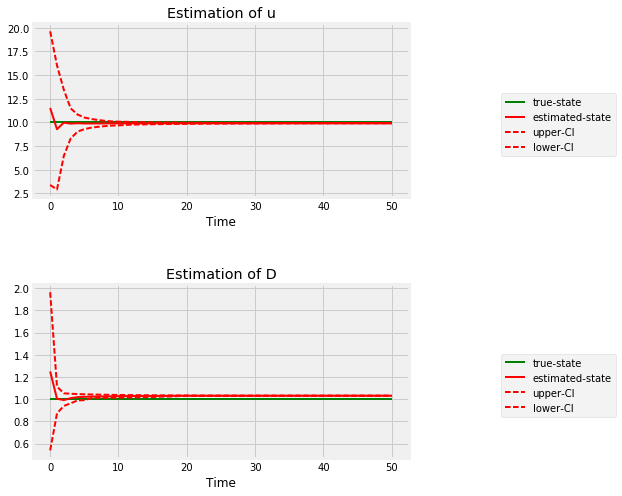

In [15]:
#結果の表示
Per_CI=0.95
    
T = total_step
num_variables = 2
m = 10000   #mは粒子の個数
ave_x = np.full([T+1,num_variables], 100, dtype=np.float)
mid_x = np.full([T+1,num_variables], 100, dtype=np.float)
lower_CI = np.full([T+1,num_variables], 100, dtype=np.float)
upper_CI = np.full([T+1,num_variables], 100, dtype=np.float)
low = int(m * (1- Per_CI) / 2) - 1
high = int(m - low) - 1

for t in range(T+1):
    u_t = sim_u[t]
    D_t = sim_D[t]
    for k in range(num_variables):
        if k == 0:
            x_t = np.sort(u_t)
        else:
            x_t = np.sort(D_t)
            
        ave_x[t][k] = np.average(x_t)
        mid_x[t][k] = np.median(x_t)
        lower_CI[t][k] = x_t[low]
        upper_CI[t][k] = x_t[high]
        
print("Estimated Value of Parameter u(truth =10)：　",sim_u[50].mean())
print("Estimated Value of Parameter D(truth =1.0)：　",sim_D[50].mean())

#結果のプロット
plt.figure(figsize=(6,num_variables*4))
plt.subplots_adjust(hspace=0.5)
for k in range(num_variables):
    plt.subplot(num_variables,1,k+1)

    if k == 0:
        plt.title("Estimation of u")
        plt.plot(np.full(T+1,10, dtype=np.float), color = 'green', linewidth=2, label="true-state")
    else:
        plt.title("Estimation of D")
        plt.plot(np.full(T+1,1, dtype=np.float), color = 'green', linewidth=2, label="true-state")
    plt.plot(ave_x.T[k], color = 'red', linewidth=2, label="estimated-state")
    plt.plot(upper_CI.T[k],'--', color = 'red', linewidth=2, label="upper-CI")
    plt.plot(lower_CI.T[k], '--', color = 'red', linewidth=2, label="lower-CI")
    plt.xlabel("Time")
    plt.legend(loc='upper right', bbox_to_anchor=(1.05,0.5,0.5,.100), borderaxespad=0.)

plt.show()

### Summary

The convergence speed of parameter estimation is very fast, and parameter estimation can be performed sequentially with effective accuracy. 
On the other hand, in order to obtain higher accuracy, it would be effective to lower the convergence speed of the parameters (scatter with MCMC etc.) or to estimate the error distribution more accurately.